In [1]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz


import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor
from utils import ModelBuilder
from utils import Predictor
pd.set_option('display.max_rows', None)

2023-07-14 22:43:57.817725: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 22:43:57.921678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [3]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [4]:
db.tables

['tickdata_jun29',
 'tickdata_jul6',
 'tickdata_jul10',
 'tickdata_jul14',
 'predictions',
 'account_summary',
 'portfolio',
 'positions',
 'tickdata_jul13']

In [19]:
input_sql_file='../sql_files/predictions.sql'
df = generate_df_from_sql_file(input_sql_file, db)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        2988 non-null   datetime64[ns]
 1   current_price    2988 non-null   float64       
 2   predicted_price  2988 non-null   float64       
 3   decision         2988 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 93.5+ KB


In [21]:
df.head()

,timestamp,current_price,predicted_price,decision
0,2023-07-10 17:22:44.881946,4438.00,4437.889648,sell ...
1,2023-07-10 17:22:47.009620,4437.75,4437.980469,buy ...
2,2023-07-10 17:22:49.091331,4438.00,4438.030762,buy ...
3,2023-07-10 17:22:51.269820,4438.00,4438.044922,buy ...
4,2023-07-10 17:22:53.383343,4437.75,4438.052734,buy ...


In [23]:
start_date = '2023-07-14'
end_date = '2023-07-15'

date_mask = (df['timestamp'] >= start_date) & (df['timestamp'] < end_date)
time_mask = (df['timestamp'].dt.time >= pd.to_datetime('17:00:00').time()) & (df['timestamp'].dt.time <= pd.to_datetime('17:25:00').time())


df = df[date_mask & time_mask]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1261 entries, 2023-07-14 17:00:00.788402 to 2023-07-14 17:24:41.828130
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   current_price    1261 non-null   float64
 1   predicted_price  1261 non-null   float64
 2   decision         1261 non-null   object 
dtypes: float64(2), object(1)
memory usage: 39.4+ KB


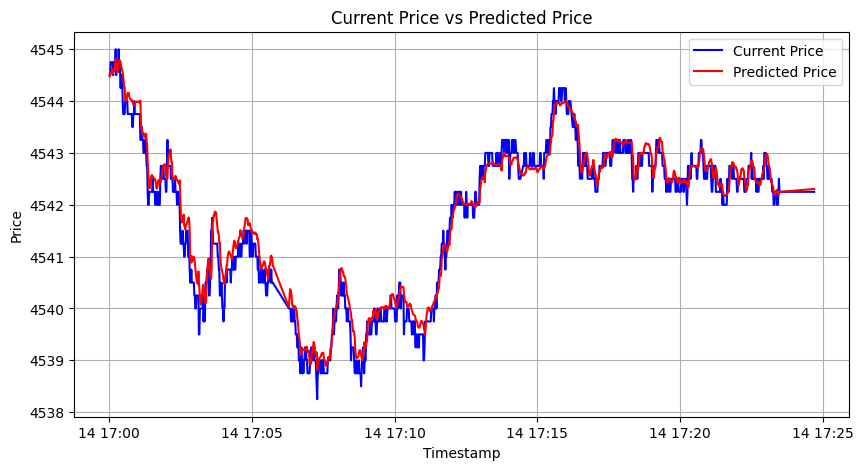

In [24]:
# Convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the timestamp as the index of the dataframe
df.set_index('timestamp', inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df['current_price'], color='blue', label='Current Price')
plt.plot(df['predicted_price'], color='red', label='Predicted Price')
plt.title('Current Price vs Predicted Price')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [30]:
df.head(50)

,ticktype,price,volume,timestamp
0,1,4546.75,0,2023-07-14 16:12:58.881223
1,2,4547.00,0,2023-07-14 16:12:58.891703
2,4,4547.00,0,2023-07-14 16:12:58.897779
3,5,0.00,2,2023-07-14 16:12:58.911454
4,5,0.00,2,2023-07-14 16:12:58.922314
5,5,0.00,5,2023-07-14 16:12:59.155622
6,4,4546.75,0,2023-07-14 16:13:00.157252
7,5,0.00,4,2023-07-14 16:13:00.181196
8,5,0.00,4,2023-07-14 16:13:00.187213
9,5,0.00,53,2023-07-14 16:13:01.156429


In [31]:
start_date = '2023-07-14'
end_date = '2023-07-15'
date_mask = (df['timestamp'] >= start_date) & (df['timestamp'] < end_date)
time_mask = (df['timestamp'].dt.time >= pd.to_datetime('17:00:00').time()) & (df['timestamp'].dt.time <= pd.to_datetime('17:25:00').time())

In [32]:
df = df[date_mask & time_mask]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5368 entries, 8107 to 13474
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ticktype   5368 non-null   int64         
 1   price      5368 non-null   float64       
 2   volume     5368 non-null   int64         
 3   timestamp  5368 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 209.7 KB
